# What is the closest location within a specific distance that will get driver the highest tip based on time of the day and day of the week?

## Preamble

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from pygeocoder import Geocoder

## Load Data

In [6]:
df = pd.read_csv("datasets/yellow_tripdata_2013-01.csv")

## Preprocess Data

In [7]:
# add day of week, pickup hour, tip percentage columns
timestamp = pd.to_datetime(pd.Series(df['pickup_datetime']))
df['day_of_week'] = timestamp.dt.weekday_name
df['pickup_hour'] = timestamp.dt.hour
df['tip_percentage'] = df.tip_amount / df.trip_distance
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,day_of_week,pickup_hour,tip_percentage
0,CMT,2013-01-01 15:11:48,2013-01-01 15:18:10,4,1.0,-73.978165,40.757977,1,N,-73.989840,...,CSH,6.5,0.0,0.5,0.0,0.0,7.0,Tuesday,15,0.0
1,CMT,2013-01-06 00:18:35,2013-01-06 00:22:54,1,1.5,-74.006680,40.731781,1,N,-73.994499,...,CSH,6.0,0.5,0.5,0.0,0.0,7.0,Sunday,0,0.0
2,CMT,2013-01-05 18:49:41,2013-01-05 18:54:23,1,1.1,-74.004711,40.737770,1,N,-74.009831,...,CSH,5.5,1.0,0.5,0.0,0.0,7.0,Saturday,18,0.0
3,CMT,2013-01-07 23:54:15,2013-01-07 23:58:20,2,0.7,-73.974600,40.759945,1,N,-73.984737,...,CSH,5.0,0.5,0.5,0.0,0.0,6.0,Monday,23,0.0
4,CMT,2013-01-07 23:25:03,2013-01-07 23:34:24,1,2.1,-73.976252,40.748528,1,N,-74.002583,...,CSH,9.5,0.5,0.5,0.0,0.0,10.5,Monday,23,0.0


In [8]:
# drop unnecessary columns
df = df.drop(['vendor_id','passenger_count','trip_distance','rate_code',
              'store_and_fwd_flag','payment_type','fare_amount','surcharge','mta_tax',
             'tip_amount','tolls_amount','total_amount','dropoff_datetime',
              'dropoff_longitude','dropoff_latitude'], axis=1)
df.head(10)

,pickup_datetime,pickup_longitude,pickup_latitude,day_of_week,pickup_hour,tip_percentage
0,2013-01-01 15:11:48,-73.978165,40.757977,Tuesday,15,0.0
1,2013-01-06 00:18:35,-74.006680,40.731781,Sunday,0,0.0
2,2013-01-05 18:49:41,-74.004711,40.737770,Saturday,18,0.0
3,2013-01-07 23:54:15,-73.974600,40.759945,Monday,23,0.0
4,2013-01-07 23:25:03,-73.976252,40.748528,Monday,23,0.0
5,2013-01-07 15:27:48,-73.966743,40.764252,Monday,15,0.0
6,2013-01-08 11:01:15,-73.995801,40.743978,Tuesday,11,0.0
7,2013-01-07 12:39:18,-73.989937,40.756773,Monday,12,0.0
8,2013-01-07 18:15:47,-73.980071,40.743138,Monday,18,0.0
9,2013-01-07 15:33:28,-73.977937,40.786983,Monday,15,0.0


## Helper Functoins

In [13]:
def mileToDegree(mile):
    return float("{:.6f}".format(mile/60))

def getMaxLocation(location, mile):
    degree = mileToDegree(mile)
    max_locations = []
    max_locations.append({'longitude': location['longitude'] - degree,
                          'latitude': location['latitude'] - degree,})
    max_locations.append({'longitude': location['longitude'] + degree,
                          'latitude': location['latitude'] + degree,})
    return max_locations


def fit_model(X, y):
    model = Pipeline([('poly', PolynomialFeatures(degree=4)),
                      ('linear', LinearRegression(fit_intercept=False))])
    model.fit(X, y)
    return model

def score_model(model, X, y, Xv, yv):
    return tuple([model.score(X, y), model.score(Xv, yv)])

def fit_model_and_score(data, response, validation, val_response):
    model = fit_model(data, response)
    return score_model(model, data, response, validation, val_response)

## Main Function

In [32]:
def polyRegression(inputs, df):
    # print inputs
    print ('inputs:')
    print ('- Day of Week: %s' %(inputs['day_of_week']))
    print ('- hour: %d' %(inputs['hour']))
    print ('- Driver Location: %s, %s' %(inputs['driver_location']['longitude'], inputs['driver_location']['latitude']))
    print ('- Distance Range: %d-mile' %(inputs['mile']))
    
    # filter data for given inputs
    max_location = getMaxLocation(inputs['driver_location'], inputs['mile'])
    df_selected = df[(df['pickup_latitude'] > max_location[0]['latitude']) & 
                     (df['pickup_longitude'] > max_location[0]['longitude']) &
                     (df['pickup_latitude'] < max_location[1]['latitude']) & 
                     (df['pickup_longitude'] < max_location[1]['longitude']) &
                     (df['pickup_hour'] == inputs['hour']) & 
                     (df['day_of_week'] == inputs['day_of_week']) &
                     (np.isfinite(df['tip_percentage']))]

    # clustering
    num_clusters = 200
    tips = df_selected['tip_percentage'].values
    lon = df_selected['pickup_longitude'].values
    lat = df_selected['pickup_latitude'].values
    coodinate_array = np.array([[lon[i],lat[i],tips[i]] for i in range(len(lon))])
    kmeans_n = KMeans(n_clusters=num_clusters, n_init=1)
    kmeans_n.fit(coodinate_array)
    df_selected['Cluster'] = kmeans_n.labels_
    
    # prepare for regression
    df_selected_cluster = df_selected.groupby('Cluster')
    cluster_tip = df_selected_cluster.tip_percentage.sum() / df_selected_cluster.size()
    cluster_tip = np.array([[cluster_tip[i]] for i in range(len(cluster_tip))])
    cluster_center = kmeans_n.cluster_centers_
    
    # train and test data
    train_size = int(len(cluster_tip)*0.8)
    test_size = int(len(cluster_tip)*0.2)
    train_feature = cluster_tip[:train_size]
    train_response = cluster_center[:train_size]
    test_feature = cluster_tip[test_size:]
    test_response = cluster_center[test_size:]
    
    # validation score
    print ('Coefficient of determination (R^2): ', 
           fit_model_and_score(train_feature, train_response, test_feature, test_response))
    
    MSE_model = Pipeline([('poly', PolynomialFeatures(degree=4)),
                          ('linear', LinearRegression(fit_intercept=False))])
    MSE_model.fit(train_feature, train_response)
    x_MSE = test_feature
    y_MSE = MSE_model.predict(x_MSE)
    print ('MSE: ', mean_squared_error(test_response, y_MSE))
    
    # prediction
    model = Pipeline([('poly', PolynomialFeatures(degree=4)),
                      ('linear', LinearRegression(fit_intercept=False))])
    model.fit(cluster_tip, cluster_center) # x: cluster_tip, y: cluster_center
    x_predict = (max(cluster_tip))
    y_predict = model.predict(x_predict)
    
    # output result
    predicted_location = Geocoder.reverse_geocode(y_predict[0][1], y_predict[0][0])
    # predicted_location.street_address might not be applicable
    if predicted_location.street_address:
        predicted_address = predicted_location.street_address
    else:
        predicted_address = '%s %s, %s' %(predicted_location.street_number, predicted_location.route, predicted_location.city)
    print ('Predicted result: ', predicted_address)
    
    # visualization
    result_x = y_predict[0][0]
    result_y = y_predict[0][1]
    plt.figure(figsize=(18,9))
    plt.scatter(lon,lat,alpha=0.2,s=100)
    plt.scatter(result_x,result_y,c='r',s=100)
    plt.scatter(inputs['driver_location']['longitude'],inputs['driver_location']['latitude'],c='w',s=100)
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.show()

inputs:
- Day of Week: Monday
- hour: 16
- Driver Location: -73.99134, 40.744712
- Distance Range: 1-mile


/Users/Linfinity/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Linfinity/anaconda/envs/py3k/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Coefficient of determination (R^2):  (0.99999999284108942, 0.99999911664743246)
MSE:  1.68235153729e-05
Predicted result:  301 East 14th Street, New York


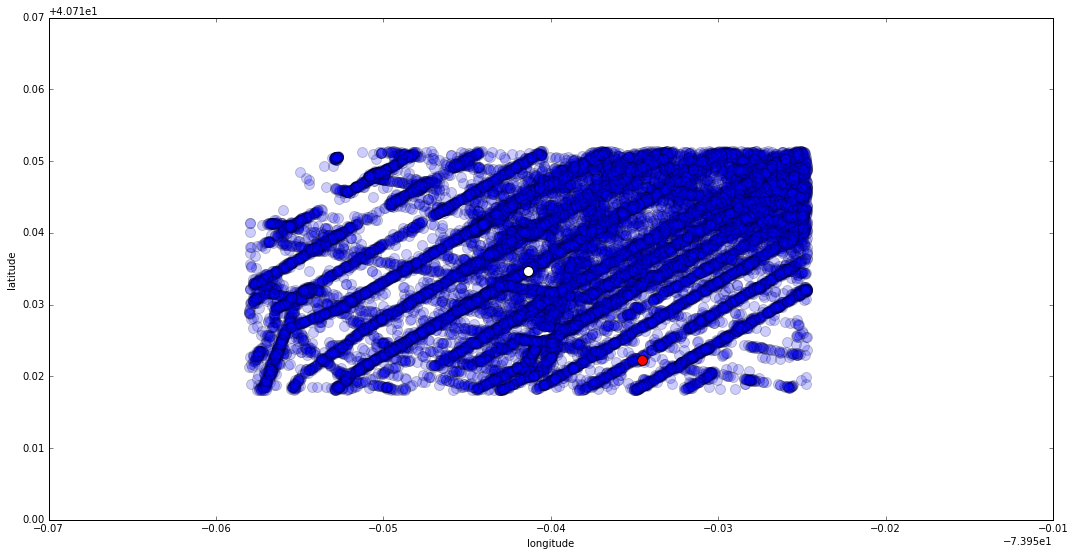

inputs:
- Day of Week: Monday
- hour: 8
- Driver Location: -73.99134, 40.744712
- Distance Range: 1-mile
Coefficient of determination (R^2):  (0.99999999547547214, 0.99999729594524311)
MSE:  2.1258519583e-05


/Users/Linfinity/anaconda/envs/py3k/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Predicted result:  343-381 East 30th Street, New York


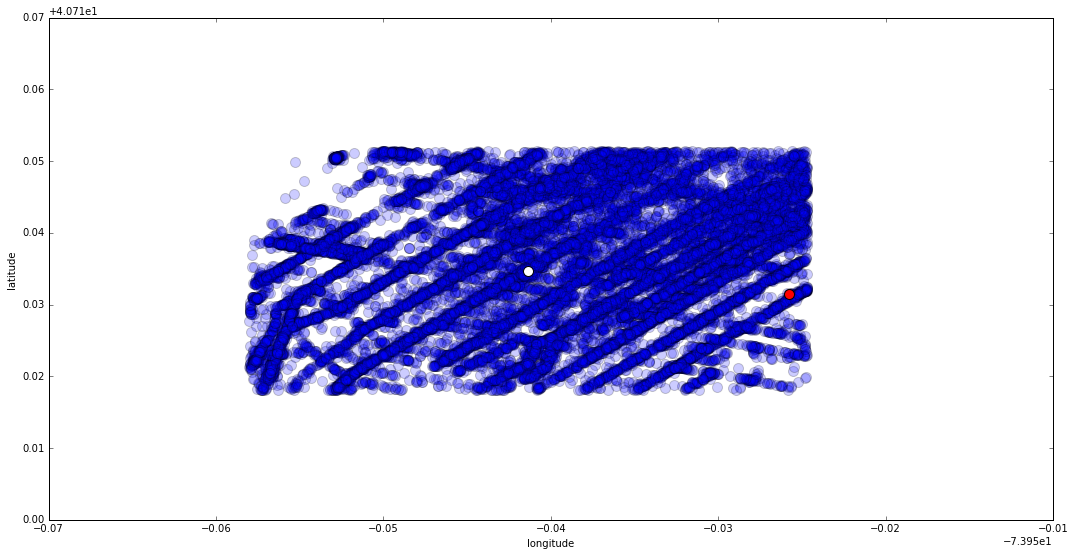

inputs:
- Day of Week: Tuesday
- hour: 10
- Driver Location: -73.99134, 40.744712
- Distance Range: 2-mile
Coefficient of determination (R^2):  (0.99999954237581146, 0.9999940542454091)
MSE:  6.93633058221e-05


/Users/Linfinity/anaconda/envs/py3k/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Predicted result:  370-375 1st Avenue, New York


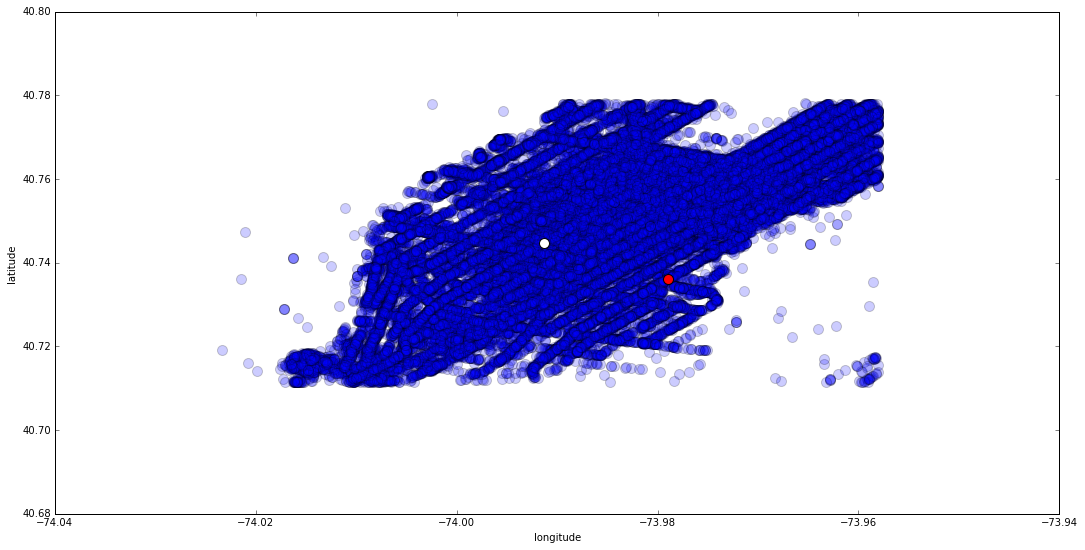

inputs:
- Day of Week: Sunday
- hour: 17
- Driver Location: -73.99134, 40.744712
- Distance Range: 1-mile
Coefficient of determination (R^2):  (0.99999996594202789, 0.99999757259839817)
MSE:  2.150255752e-05
Predicted result:  653 5th Avenue, New York


/Users/Linfinity/anaconda/envs/py3k/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


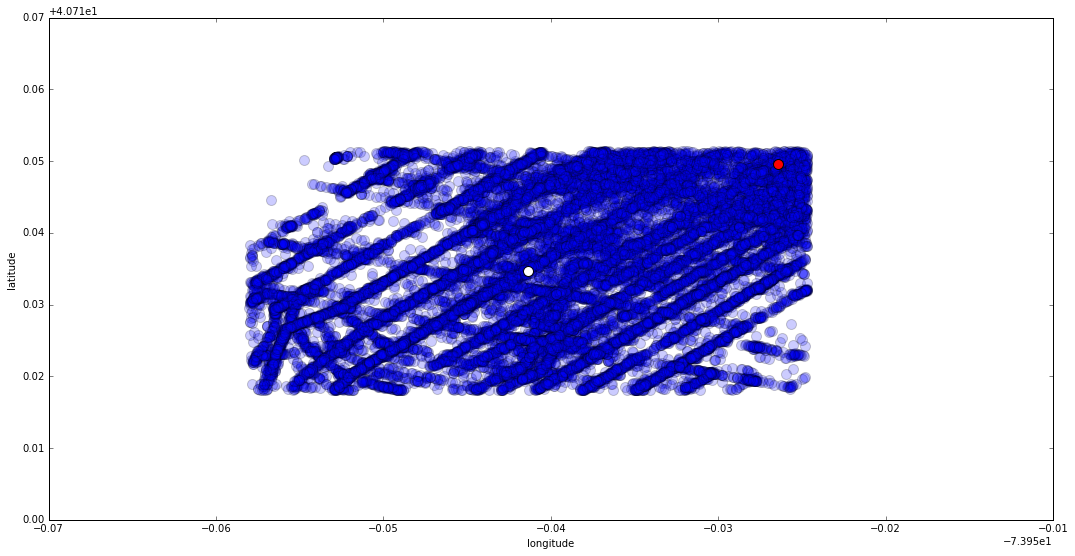

In [33]:
inputs_arr = [{'mile': 1,
               'driver_location': {'longitude': -73.991340,'latitude': 40.744712}, # 38-98 West 26th Street, New York
               'hour': 16,
               'day_of_week': 'Monday'},
              {'mile': 1,
               'driver_location': {'longitude': -73.991340,'latitude': 40.744712},
               'hour': 8,
               'day_of_week': 'Monday'},
              {'mile': 2,
               'driver_location': {'longitude': -73.991340,'latitude': 40.744712},
               'hour': 10,
               'day_of_week': 'Tuesday'},
              {'mile': 1,
               'driver_location': {'longitude': -73.991340,'latitude': 40.744712},
               'hour': 17,
               'day_of_week': 'Sunday'},
             ]
              
for inputs in inputs_arr:
    polyRegression(inputs, df)